# Instagram Comments Cleaning

This notebook cleans the comment column in the Instagram comments Excel file.


In [3]:
import pandas as pd
import html
from bs4 import BeautifulSoup
import re
import os

In [13]:
# Load the Excel file with multiple sheets
file_path = 'sgsmu.studentcare_instagram_comments.xlsx'  # Update this path if needed

try:
    # Read all sheets
    sheets = pd.read_excel(file_path, sheet_name=None)
    print("Loaded Excel file with sheets:", list(sheets.keys()))
except FileNotFoundError:
    print("Excel file not found. Trying to load CSV instead.")
    csv_path = '../terrs-EDA_instagram_reddit_telegram/Notebook Analysis/data sources/Instagram - sgsmu.studentcare - Post to Comments.csv'
    df = pd.read_csv(csv_path)
    sheets = {'Sheet1': df}  # Treat as one sheet
    print("Loaded CSV file as single sheet.")

# Dictionary to hold cleaned dataframes
cleaned_sheets = {}

Loaded Excel file with sheets: ['Post 1', 'Post 2', 'Post 3', 'Post 4', 'Post 5', 'Post 6', 'Post 7', 'Post 8']


In [14]:
def clean_comment(text):
    if pd.isna(text) or text == '':
        return ''
    
    # Remove HTML tags
    soup = BeautifulSoup(str(text), 'html.parser')
    text = soup.get_text()
    
    # Unescape HTML entities
    text = html.unescape(text)
    
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove emojis and non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [15]:
# Clean each sheet
for sheet_name, df in sheets.items():
    if df.shape[1] >= 4:  # Ensure at least 4 columns (D is 4th, 0-indexed as 3)
        # Remove rows where Username is 'sgsmu.studentcare' (the post itself)
        if 'Username' in df.columns:
            df = df[df['Username'] != 'sgsmu.studentcare']
        df.iloc[:, 3] = df.iloc[:, 3].apply(clean_comment)  # Column D (index 3)
        # Remove rows where Comment is empty after cleaning
        df = df[df.iloc[:, 3] != '']
        cleaned_sheets[sheet_name] = df
        print(f"Cleaned sheet: {sheet_name}")
    else:
        print(f"Warning: Not enough columns in sheet {sheet_name}")
        cleaned_sheets[sheet_name] = df

Cleaned sheet: Post 1
Cleaned sheet: Post 2
Cleaned sheet: Post 3
Cleaned sheet: Post 4
Cleaned sheet: Post 5
Cleaned sheet: Post 6
Cleaned sheet: Post 7
Cleaned sheet: Post 8


In [16]:
# Reset cleaned_sheets and re-clean with updated function
cleaned_sheets = {}

# Clean each sheet again
for sheet_name, df in sheets.items():
    if df.shape[1] >= 4:  # Ensure at least 4 columns (D is 4th, 0-indexed as 3)
        # Remove rows where Username is 'sgsmu.studentcare' (the post itself)
        if 'Username' in df.columns:
            df = df[df['Username'] != 'sgsmu.studentcare']
        df.iloc[:, 3] = df.iloc[:, 3].apply(clean_comment)  # Column D (index 3)
        # Remove rows where Comment is empty after cleaning
        df = df[df.iloc[:, 3] != '']
        cleaned_sheets[sheet_name] = df
        print(f"Re-cleaned sheet: {sheet_name}")
    else:
        print(f"Warning: Not enough columns in sheet {sheet_name}")
        cleaned_sheets[sheet_name] = df

Re-cleaned sheet: Post 1
Re-cleaned sheet: Post 2
Re-cleaned sheet: Post 3
Re-cleaned sheet: Post 4
Re-cleaned sheet: Post 5
Re-cleaned sheet: Post 6
Re-cleaned sheet: Post 7
Re-cleaned sheet: Post 8


In [17]:
# Save the cleaned data to a new Excel file
output_file = 'sgsmu.studentcare_instagram_comments_cleaned.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for sheet_name, df in cleaned_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Cleaned file saved as: {output_file}")

Cleaned file saved as: sgsmu.studentcare_instagram_comments_cleaned.xlsx


In [9]:
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter

# Download NLTK data
nltk.download('stopwords', quiet=True)

True

In [18]:
# Combine all sheets into one dataframe for analysis
all_comments = []
for sheet_name, df in cleaned_sheets.items():
    df_copy = df.copy()
    df_copy['Post'] = sheet_name
    all_comments.append(df_copy)

combined_df = pd.concat(all_comments, ignore_index=True)
print(f"Total comments: {len(combined_df)}")
print(combined_df.head())

Total comments: 1904
  Link Question           Username             Comment    Post
0  NaN      NaN  adhitya._.adhitya          More sleep  Post 1
1  NaN      NaN           imchloek      exercise more~  Post 1
2  NaN      NaN          k.aisheng               Sleep  Post 1
3  NaN      NaN           cnchloee  i shld eat more :>  Post 1
4  NaN      NaN            gymxgoh     sleep more!!!!!  Post 1


In [11]:
# Sentiment Analysis
def get_sentiment(text):
    if pd.isna(text) or text.strip() == '':
        return 'neutral'
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

combined_df['Sentiment'] = combined_df.iloc[:, 3].apply(get_sentiment)  # Column D

# Sentiment distribution
sentiment_counts = combined_df['Sentiment'].value_counts()
print(sentiment_counts)

Sentiment
neutral     1214
positive     607
negative      95
Name: count, dtype: int64


In [12]:
# Word Frequency Analysis
stop_words = set(stopwords.words('english'))
additional_stops = {'sleep', 'more', 'less', 'exercise', 'eat', 'drink', 'coffee', 'study', 'work', 'school', 'time', 'day', 'week', 'month', 'year', 'good', 'bad', 'better', 'worse', 'much', 'little', 'lot', 'need', 'want', 'like', 'love', 'hate', 'feel', 'think', 'know', 'get', 'make', 'take', 'give', 'come', 'go', 'see', 'look', 'say', 'tell', 'ask', 'answer', 'question', 'comment', 'post', 'instagram', 'sgsmu', 'studentcare'}
stop_words.update(additional_stops)

all_text = ' '.join(combined_df.iloc[:, 3].dropna().astype(str))
words = [word.lower() for word in all_text.split() if word.lower() not in stop_words and len(word) > 2]
word_freq = Counter(words)
top_words = word_freq.most_common(20)
print("Top 20 words:", top_words)

Top 20 words: [('stress', 213), ('management', 159), ('friends', 81), ('try', 54), ('destress', 48), ('friend', 41), ('tips', 40), ('more!', 36), ('new', 35), ('life', 34), ('spending', 33), ('always', 30), ('career', 29), ('mental', 28), ('food', 28), ('spend', 27), ('financial', 27), ('burnout', 27), ('earlier', 26), ('going', 25)]


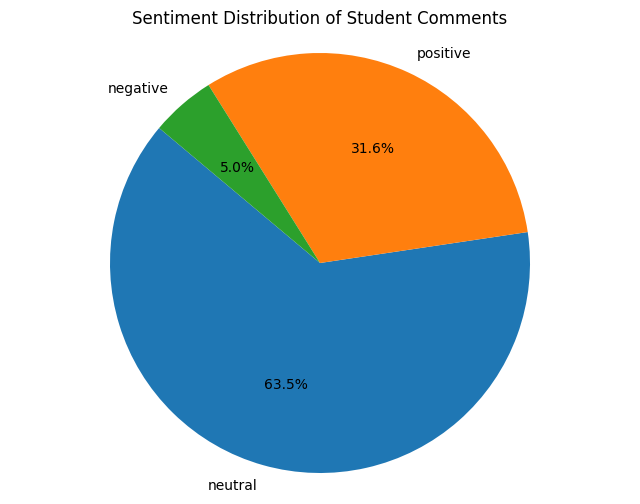

In [11]:
# Sentiment Distribution Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution of Student Comments')
plt.axis('equal')
plt.show()

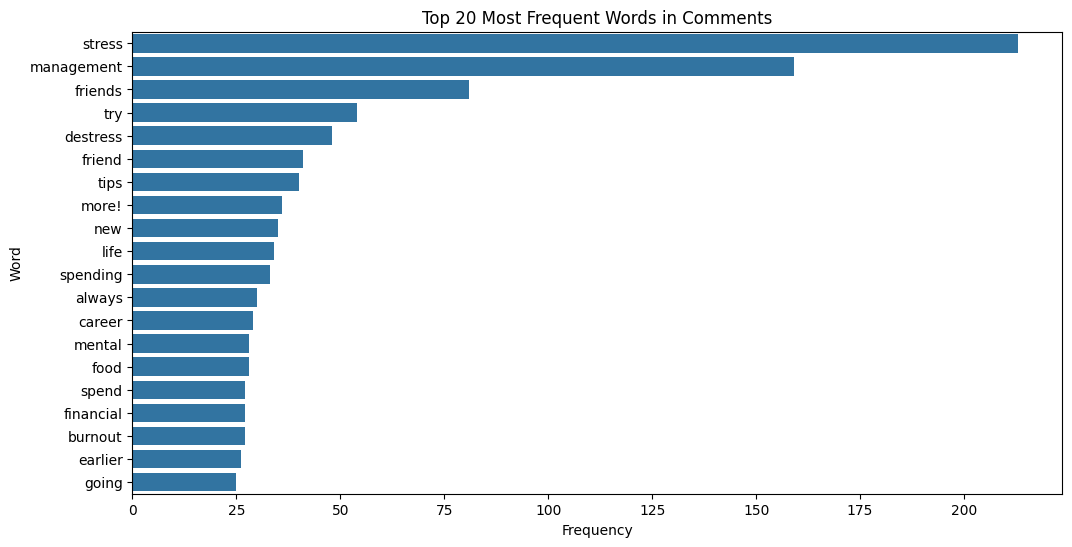

In [12]:
# Top Words Bar Chart
words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=words_df)
plt.title('Top 20 Most Frequent Words in Comments')
plt.show()

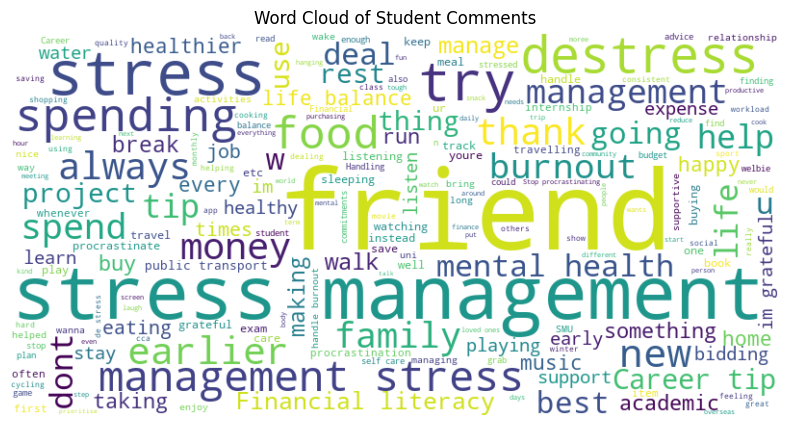

In [13]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Student Comments')
plt.show()

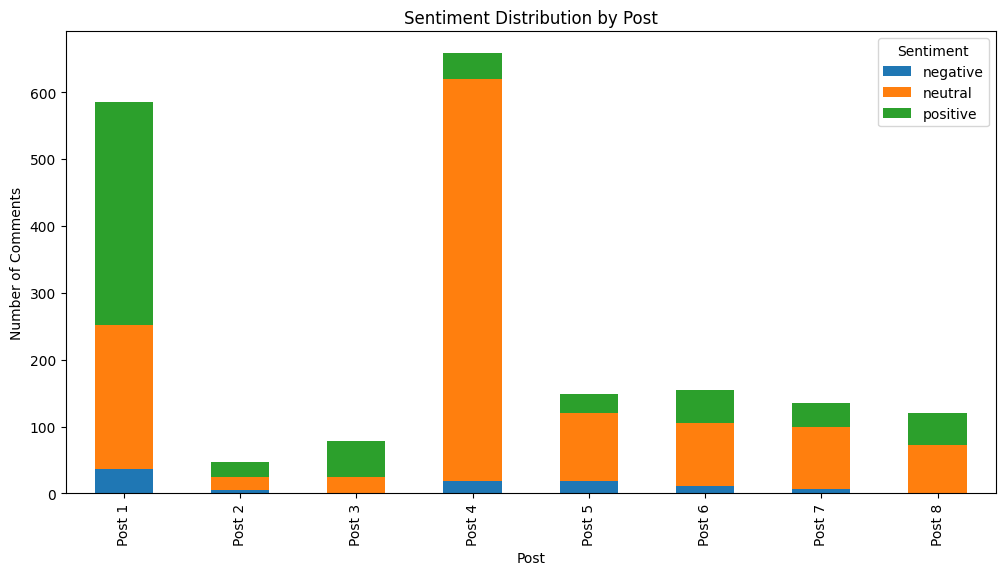

In [14]:
# Sentiment by Post
sentiment_by_post = combined_df.groupby(['Post', 'Sentiment']).size().unstack(fill_value=0)
sentiment_by_post.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution by Post')
plt.ylabel('Number of Comments')
plt.show()